In [44]:
import data_loader
import numpy as np
import image_util
import matplotlib.pyplot as plt
import core
import matplotlib.pylab as pylab

params = {
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'legend.fontsize': 20,
          }
pylab.rcParams.update(params)
data_mat = data_loader.get_clustering_data_matrix().T
data_labels = data_loader.get_clustering_data_label()

DPI = 120
IMG_PATH_PREFIX = 'writeup/images/'

In [31]:
from image_util import vector_to_img
import matplotlib.pyplot as plt
import math

def show_cluster(data_mat, img_ids):
  ncols = 8
  nrows = math.ceil(len(img_ids) / ncols) 
  figsize = (ncols * 3, nrows * 3)
  fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
  for ax in axes.flatten():
    ax.axis('off')
  for i, img_id in enumerate(img_ids):
    r = i // ncols
    c = i % ncols
    if nrows == 1:
      ax = axes[c]
    else:
      ax = axes[r,c]
    ax.axis('on')
    image_util.show_image(ax, vector_to_img(data_mat[img_id,:], data_loader.CROPPED_IMG_SHAPE))

# Cluster based on lighting, KMeans

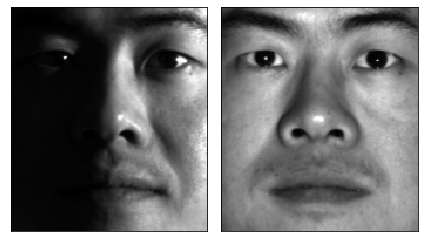

In [32]:
import data_loader
from data_loader import Lighting, load_cropped_image
fig, axes = plt.subplots(nrows = 1, ncols = 2)
image_util.show_image(axes[0], load_cropped_image(2, Lighting.LEFT_DARK))
image_util.show_image(axes[1], load_cropped_image(2, Lighting.BRIGHT))
# Sample pictures that we are planning to cluster on.

fig.tight_layout()
fig.savefig(IMG_PATH_PREFIX + 'cluster_samples.png', format='png', dpi=DPI)

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(data_mat)
print(core.score_cluster(kmeans.labels_, data_labels))
cluster0 = np.argwhere(kmeans.labels_ == 0).flatten()
cluster1 = np.argwhere(kmeans.labels_ == 1).flatten()
#show_cluster(data_mat, cluster0)

1.0


In [34]:
#show_cluster(data_mat, cluster1)

# Cluster with GMM

In [35]:
from sklearn import mixture

gmm_labels = mixture.GaussianMixture(n_components=2, covariance_type='diag', random_state=0)\
    .fit_predict(data_mat)
print(core.score_cluster(gmm_labels, data_labels))
cluster0 = np.argwhere(gmm_labels == 0).flatten()
cluster1 = np.argwhere(gmm_labels == 1).flatten()
#show_cluster(data_mat, cluster0)

1.0


In [36]:
# show_cluster(data_mat, cluster1)

# Cluster on lighting, Kmeans, 2 D

In [37]:
def get_dim_reduced_mat(data_mat, r):
  """Perform dimensionality reduction through SVD.
  Parameters:
  - data_mat (d x n np array), each column is a flattened image.
  Return;
  - reduced dimension data_mat (r x n np array), where r << d.

  How:
  - Get average face by getting column mean.
  - Subtract that average face from every column.
  - Perform SVD on the average-subtracted matrix.
  - The U from SVD is of shape d x r.
  - Each of U's columns is a d x 1 vector an eigen face.
  - Given an image vector, d x 1, you can then convert to a (r x 1) low D vector by projecting
    against each of the r eigenfaces, each also of dimension (d x 1).
  - That is, given image_vec = d x 1, you just do Ut @ image_vec to get an r x 1 low-dimensional vector.
  - So, given the entire data matrix of size d x n, you just do Ut @ data_mat to get an r x n matrix.
  """
  avg_face = data_mat.mean(axis = 1)
  avg_removed_mat =  (data_mat.T - avg_face).T
  u, s, vh = np.linalg.svd(avg_removed_mat, full_matrices = False)
  ur = u[:,:r]
  return ur.T @ avg_removed_mat
dim_reduced_mat = get_dim_reduced_mat(data_mat.T, r = 2)

In [38]:
def plot_2d(ax):
  # Plot on 2D.
  bright_coords = []
  dark_coords = []
  for img_i in range(dim_reduced_mat.shape[1]):
    coord = dim_reduced_mat[:, img_i]
    if data_labels[img_i] == 1:
      bright_coords.append(coord)
    else:
      dark_coords.append(coord)

  bright_coords_xy = list(zip(*bright_coords))
  dark_coords_xy = list(zip(*dark_coords))

  ax.scatter(bright_coords_xy[0], bright_coords_xy[1], c = 'red', label = 'Bright')
  ax.scatter(dark_coords_xy[0], dark_coords_xy[1], c = 'blue', label = 'Dark')
  ax.legend()

1.0


(-15000, 18000)

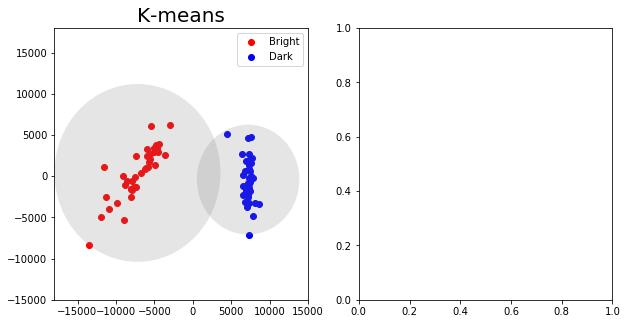

In [39]:
from scipy.spatial import distance
# Kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(dim_reduced_mat.T)
print(core.score_cluster(kmeans.labels_, data_labels))

# Plot kmeans centers
# Radius of each center = to reach the furthest points.
cluster_radii = []
for ci, center in enumerate(kmeans.cluster_centers_):
  distances = []
  pts = dim_reduced_mat[:,kmeans.labels_ == ci]
  for pt_i in range(pts.shape[1]):
    distances.append(distance.euclidean(pts[:, pt_i], center))
  cluster_radii.append(np.max(distances))

fig, axes = plt.subplots(ncols = 2, figsize=(10,5))
ax = axes[0]
ax.set_title("K-means")
plot_2d(ax)
for c, r in zip(kmeans.cluster_centers_, cluster_radii):
  ax.add_patch(plt.Circle(c, r, alpha=0.2, fc = "grey"))
ax.set_xlim(-18000, 15000)
ax.set_ylim(-15000, 18000)


In [40]:
from matplotlib.patches import Ellipse
# GMM
gmm = mixture.GaussianMixture(n_components=2, random_state=0)
gmm_labels = gmm.fit_predict(dim_reduced_mat.T)
print(core.score_cluster(gmm_labels, data_labels))

# Code taken from scipy
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
ax = axes[1]
plot_2d(ax)
for i in range(len(gmm.means_)):
  center = gmm.means_[i]
  covars = gmm.covariances_[i]
  
  v, w = np.linalg.eigh(covars)
  u = w[0] / np.linalg.norm(w[0])
  angle = np.arctan2(u[1], u[0])
  angle = 180 * angle / np.pi  # convert to degrees
  v = 2. * np.sqrt(2.) * np.sqrt(v)
  ell = Ellipse(center, v[0], v[1],
                            180 + angle, color="grey", alpha=0.2)
  ell.set_clip_box(ax.bbox)
  ell.set_alpha(0.5)
  ax.add_artist(ell)
ax.set_title("GMM")
fig.tight_layout()
fig.savefig(IMG_PATH_PREFIX + 'cluster_lowd.png', format='png', dpi=DPI)

1.0


# Clustering performance with varying dimensions

In [29]:
kmeans_scores = []
gmm_scores = []
rs = [2,10,50,100,500,1000,10000,100000]
for r in rs:
  dim_reduced_mat = get_dim_reduced_mat(data_mat.T, r)
  kmeans = KMeans(n_clusters=2, random_state=0).fit(dim_reduced_mat.T)
  kmeans_scores.append(core.score_cluster(kmeans.labels_, data_labels))
  gmm_labels = mixture.GaussianMixture(n_components=2, covariance_type='diag', random_state=0) \
    .fit_predict(dim_reduced_mat.T)
  gmm_scores.append(core.score_cluster(gmm_labels, data_labels))

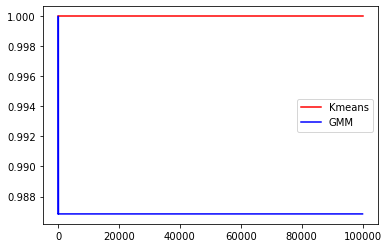

In [13]:
fig, ax = plt.subplots()
ax.plot(rs, kmeans_scores, c = "red", label = "Kmeans")
ax.plot(rs, gmm_scores, c = "blue", label ="GMM")
ax.legend()

# Cluster on just bright

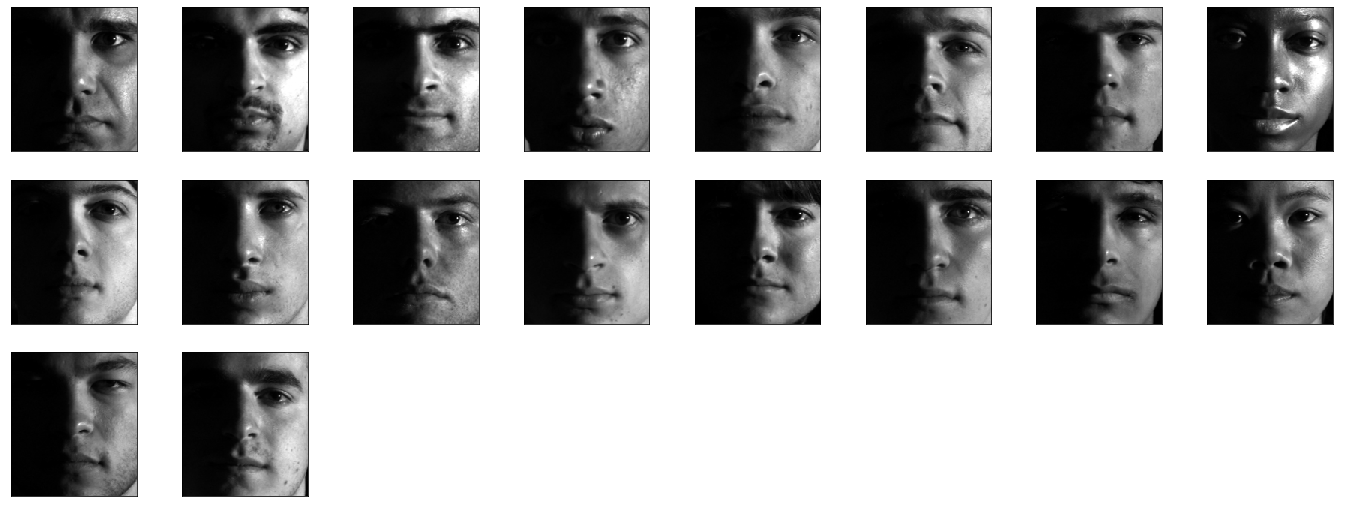

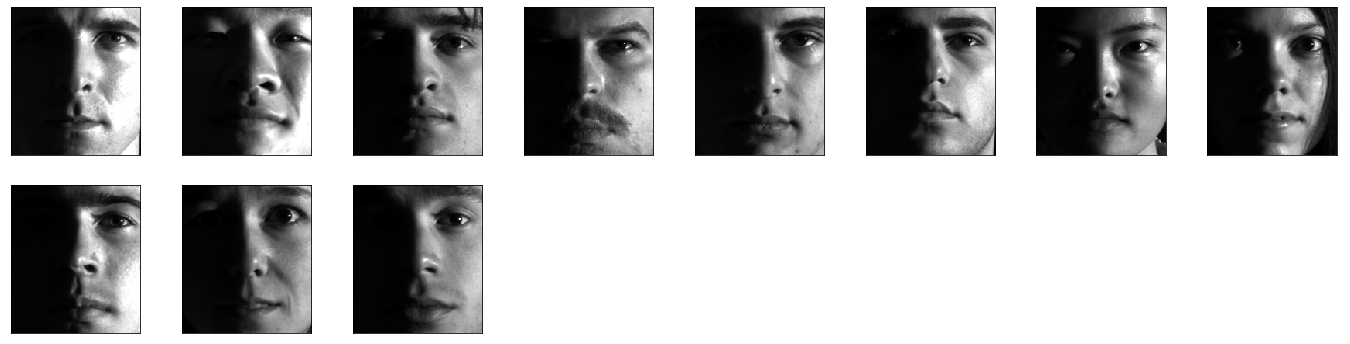

In [14]:
from sklearn.cluster import KMeans
bright_data_mat = data_loader.get_gender_train_matrix().T

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bright_data_mat)
for cluster_id in range(n_clusters):
  ids_in_cluster = np.argwhere(kmeans.labels_ == cluster_id).flatten()
  show_cluster(data_mat, ids_in_cluster)